In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec


In [3]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [8]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{stn_id}_station_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

In [15]:
len(df["ID"])

9841

## number of neighbours

In [16]:
def calc_stn_count(spec_id):
    count = []
    df_stns = pd.read_csv(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_qc/{spec_id}_station_moving_list_all_events.csv')
    for days in range(0,df_stns["Day"].max()+1):
        count.append(len(df_stns[df_stns["Day"]==days]))
    return np.nanmean(count)  

In [ ]:
max_pool=24
with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(calc_stn_count,
                   df["ID"]),
            total=len(df["ID"]),
            position=0, leave=True
        )
    )
p.join()

 68%|██████▊   | 6716/9841 [06:04<02:41, 19.30it/s]

In [ ]:
mean_count = [data for data in pool_outputs]
df["neighb_count"] = mean_count


In [ ]:
base_cmap = cmc.nuuk_r # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_nuuk", colors)

In [ ]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s = 2, c= mean_count, cmap=custom_cmap,vmin=0,vmax=800,#norm=mcolors.LogNorm(vmax=1000),
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Station count")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [ ]:
df.to_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_staitons_count_inc.csv")


## Figure 1

In [1]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp")  # Replace with your shapefile path


KeyboardInterrupt



In [ ]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")


In [ ]:
WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SSWFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"] # SFW
SSWFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"] # SFE
SSVW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"] # VICW
SSVE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"] # VICE
SSTW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"] # TASW
SSTE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"] # TASE
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

In [7]:
df_neib = pd.read_csv("/g/data/k10/dl6968/Rain_gauge_scale/BoM_staitons_count_inc.csv")

In [8]:
geometry = [Point(xy) for xy in zip(df_neib["Longitude"], df_neib["Latitude"])]
neib_gdf = gpd.GeoDataFrame(df_neib, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
neib_with_regions = gpd.sjoin(neib_gdf, regions_gdf, how="left", predicate="within")


/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1204: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [9]:
WT_neib =  neib_with_regions[neib_with_regions["code"]=="WT"]
SSWFW_neib =  neib_with_regions[neib_with_regions["code"]=="SSWFW"]
SSWFE_neib =  neib_with_regions[neib_with_regions["code"]=="SSWFE"]
SSVW_neib =  neib_with_regions[neib_with_regions["code"]=="SSVW"]
SSVE_neib =  neib_with_regions[neib_with_regions["code"]=="SSVE"]
SSTW_neib =  neib_with_regions[neib_with_regions["code"]=="SSTW"]
SSTE_neib =  neib_with_regions[neib_with_regions["code"]=="SSTE"]
RW_neib =  neib_with_regions[neib_with_regions["code"]=="RW"]
RE_neib =  neib_with_regions[neib_with_regions["code"]=="RE"]
MNW_neib =  neib_with_regions[neib_with_regions["code"]=="MNW"]
MNE_neib =  neib_with_regions[neib_with_regions["code"]=="MNE"]
MB_neib =  neib_with_regions[neib_with_regions["code"]=="MB"]
ECS_neib =  neib_with_regions[neib_with_regions["code"]=="ECS"]
ECN_neib =  neib_with_regions[neib_with_regions["code"]=="ECN"]
CS_neib = neib_with_regions[neib_with_regions["code"]=="CS"]

In [10]:
base_cmap = cmc.nuuk_r # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_nuuk", colors)

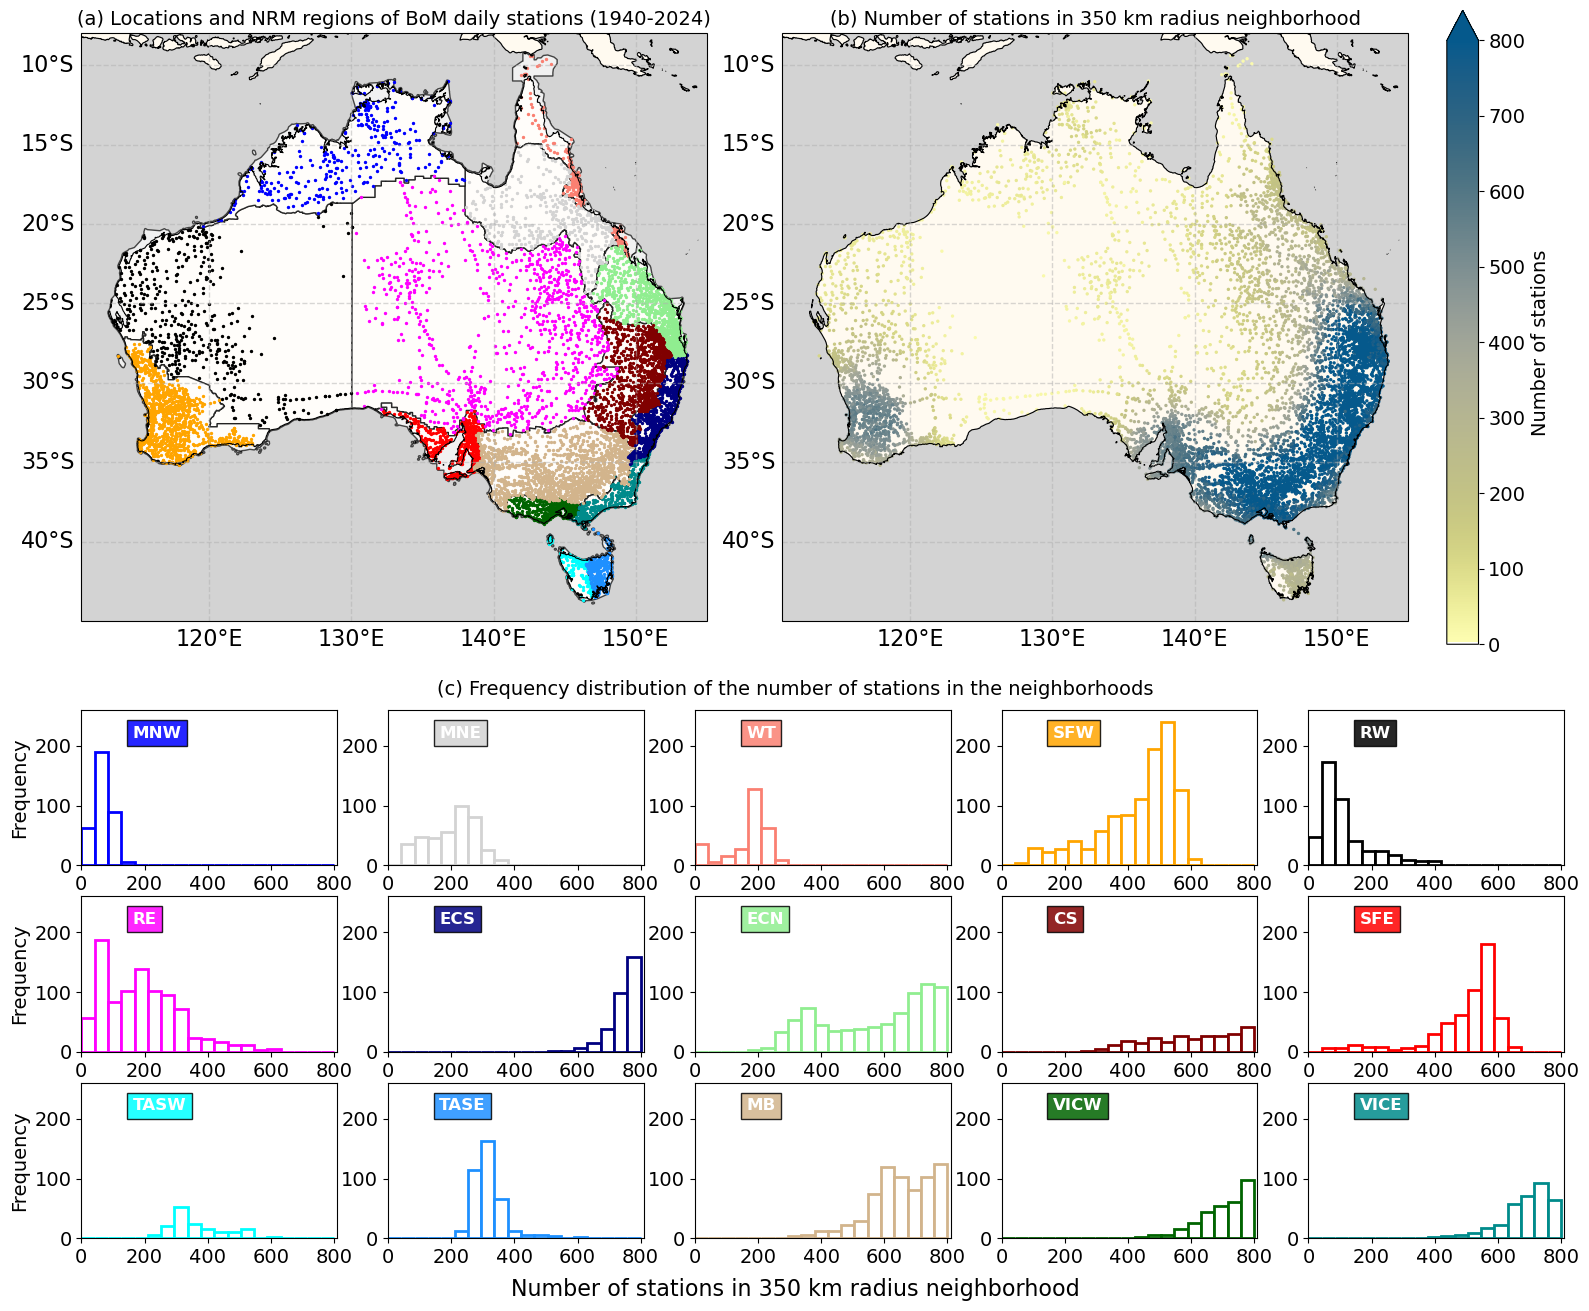

In [11]:
fig = plt.figure(figsize=(16,14))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.25],height_ratios=[1.5, 1])  # First column is 1, second is 1.5x wider

# First subplot (narrower column)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

plt.scatter(WT_stn["Longitude"], WT_stn["Latitude"], s = 2, color= "salmon",  label="WT",
            transform=ccrs.PlateCarree())
plt.scatter(SSWFW_stn["Longitude"], SSWFW_stn["Latitude"], s = 2, color= "orange",  label="SFW",
            transform=ccrs.PlateCarree())
plt.scatter(SSWFE_stn["Longitude"], SSWFE_stn["Latitude"], s = 2, color= "red",  label="SFE",
            transform=ccrs.PlateCarree())
plt.scatter(SSVW_stn["Longitude"], SSVW_stn["Latitude"], s = 2, color= "darkgreen",  label="VICW",
            transform=ccrs.PlateCarree())
plt.scatter(SSVE_stn["Longitude"], SSVE_stn["Latitude"], s = 2, color= "darkcyan",  label="VICE",
            transform=ccrs.PlateCarree())
plt.scatter(SSTW_stn["Longitude"], SSTW_stn["Latitude"], s = 2, color= "cyan",  label="TASW",
            transform=ccrs.PlateCarree())
plt.scatter(SSTE_stn["Longitude"], SSTE_stn["Latitude"], s = 2, color= "dodgerblue",  label="TASE",
            transform=ccrs.PlateCarree())
plt.scatter(RW_stn["Longitude"], RW_stn["Latitude"], s = 2, color= "black",  label="RW",
            transform=ccrs.PlateCarree())
plt.scatter(RE_stn["Longitude"], RE_stn["Latitude"], s = 2, color= "fuchsia",  label="RE",
            transform=ccrs.PlateCarree())
plt.scatter(MNW_stn["Longitude"], MNW_stn["Latitude"], s = 2, color= "blue",  label="MNW",
            transform=ccrs.PlateCarree())
plt.scatter(MNE_stn["Longitude"], MNE_stn["Latitude"], s = 2, color= "lightgray",  label="MNE",
            transform=ccrs.PlateCarree())
plt.scatter(MB_stn["Longitude"], MB_stn["Latitude"], s = 2, color= "tan",  label="MB",
            transform=ccrs.PlateCarree())
plt.scatter(ECS_stn["Longitude"], ECS_stn["Latitude"], s = 2, color= "navy",  label="ECS",
            transform=ccrs.PlateCarree())
plt.scatter(ECN_stn["Longitude"], ECN_stn["Latitude"], s = 2, color= "lightgreen",  label="ECN",
            transform=ccrs.PlateCarree())
plt.scatter(CS_stn["Longitude"], CS_stn["Latitude"], s = 2, color= "maroon",  label="CS",
            transform=ccrs.PlateCarree())
plt.title("(a) Locations and NRM regions of BoM daily stations (1940-2024)")
regions_gdf.plot(ax=ax1, color="w", edgecolor="black", alpha=0.7,zorder=0)


# plt.legend(loc="lower left", ncol =2)
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}  # Font size for longitude labels
gl.ylabel_style = {'size': 16}  # Font size for latitude labels
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='lightgrey')  
ax1.set_ylim([-45,-8])
ax1.set_xlim([111,155])

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
plt.scatter(df_neib["Longitude"], df_neib["Latitude"], s = 2, c= df_neib["neighb_count"], cmap=custom_cmap,vmin=0,vmax=800,#norm=mcolors.LogNorm(vmax=1000),
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max",shrink=0.8)
cbar.ax.set_ylabel("Number of stations")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}  # Font size for longitude labels
gl.ylabel_style = {'size': 16}  # Font size for latitude labels
ax2.set_ylim([-45,-8])
ax2.set_xlim([111,155])

ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='lightgrey')  
## have this so the plots are the same size
regions_gdf.plot(ax=ax2, color="w", edgecolor="w", alpha=0,zorder=0)
plt.title("(b) Number of stations in 350 km radius neighborhood")



gs_bottom = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs[1, :], wspace=0.2, hspace=0.2)

datasets = [
    (MNW_neib, "blue"), (MNE_neib, "lightgray"), (WT_neib, "salmon"),
    (SSWFW_neib, "orange"), (RW_neib, "black"), (RE_neib, "fuchsia"),
    (ECS_neib, "navy"), (ECN_neib, "lightgreen"), (CS_neib, "maroon"),
    (SSWFE_neib, "red"), (SSTW_neib, "cyan"), (SSTE_neib, "dodgerblue"),
    (MB_neib, "tan"), (SSVW_neib, "darkgreen"), (SSVE_neib, "darkcyan")
]

for i, ((data, color), label) in enumerate(zip(datasets, [
    "MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"])):
    
    ax_hist = fig.add_subplot(gs_bottom[i // 5, i % 5])
    ax_hist.hist(data["neighb_count"], histtype="bar", bins=np.linspace(0, 800, 20), 
                 facecolor="w", edgecolor=color, linewidth=2)
    ax_hist.set_ylim([0, 260])
    ax_hist.set_xlim([0, 810])
    ax_hist.set_xticks([0, 200, 400, 600, 800])
    
    # Add label inside each histogram panel
    ax_hist.text(0.2, 0.9, label, transform=ax_hist.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=color, alpha=0.85))

    # Add y-axis labels only to the first column
    if i % 5 == 0:
        ax_hist.set_ylabel("Frequency")
# gs_bottom.suptitle("(c) Frequency distribution of the number of stations in the neighborhoods")
fig.suptitle("(c) Frequency distribution of the number of stations in the neighborhoods",
             fontsize=14, y=0.43, x=0.5, ha='center')

fig.text(0.5, -0.01, "Number of stations in 350 km radius neighborhood", ha='center', fontsize=16)




plt.tight_layout()

# plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_01.png", dpi=200, bbox_inches="tight")

## seasonal P90

In [21]:
df_pc_season = pd.read_csv("/g/data/k10/dl6968/Semi-variogram_AU/data/BoM_stn_p90_monthly.csv")
df_p90 = df_pc_season[df_pc_season["ID"].isin(df["ID"])]

In [28]:
df_season = df_p90.copy()
df_season["DJF"] = (df_p90["Dec"].values + df_p90["Jan"].values + df_p90["Feb"].values)/3
df_season["MAM"]  = (df_p90["Mar"].values + df_p90["Apr"].values + df_p90["May"].values)/3
df_season["JJA"]  = (df_p90["Jun"].values + df_p90["Jul"].values + df_p90["Aug"].values)/3
df_season["SON"]  = (df_p90["Sep"].values + df_p90["Oct"].values + df_p90["Nov"].values)/3


In [25]:
base_cmap = cmc.roma # Choose a base colormap
colors = base_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
custom_cmap = LinearSegmentedColormap.from_list("Custom_roma", colors)

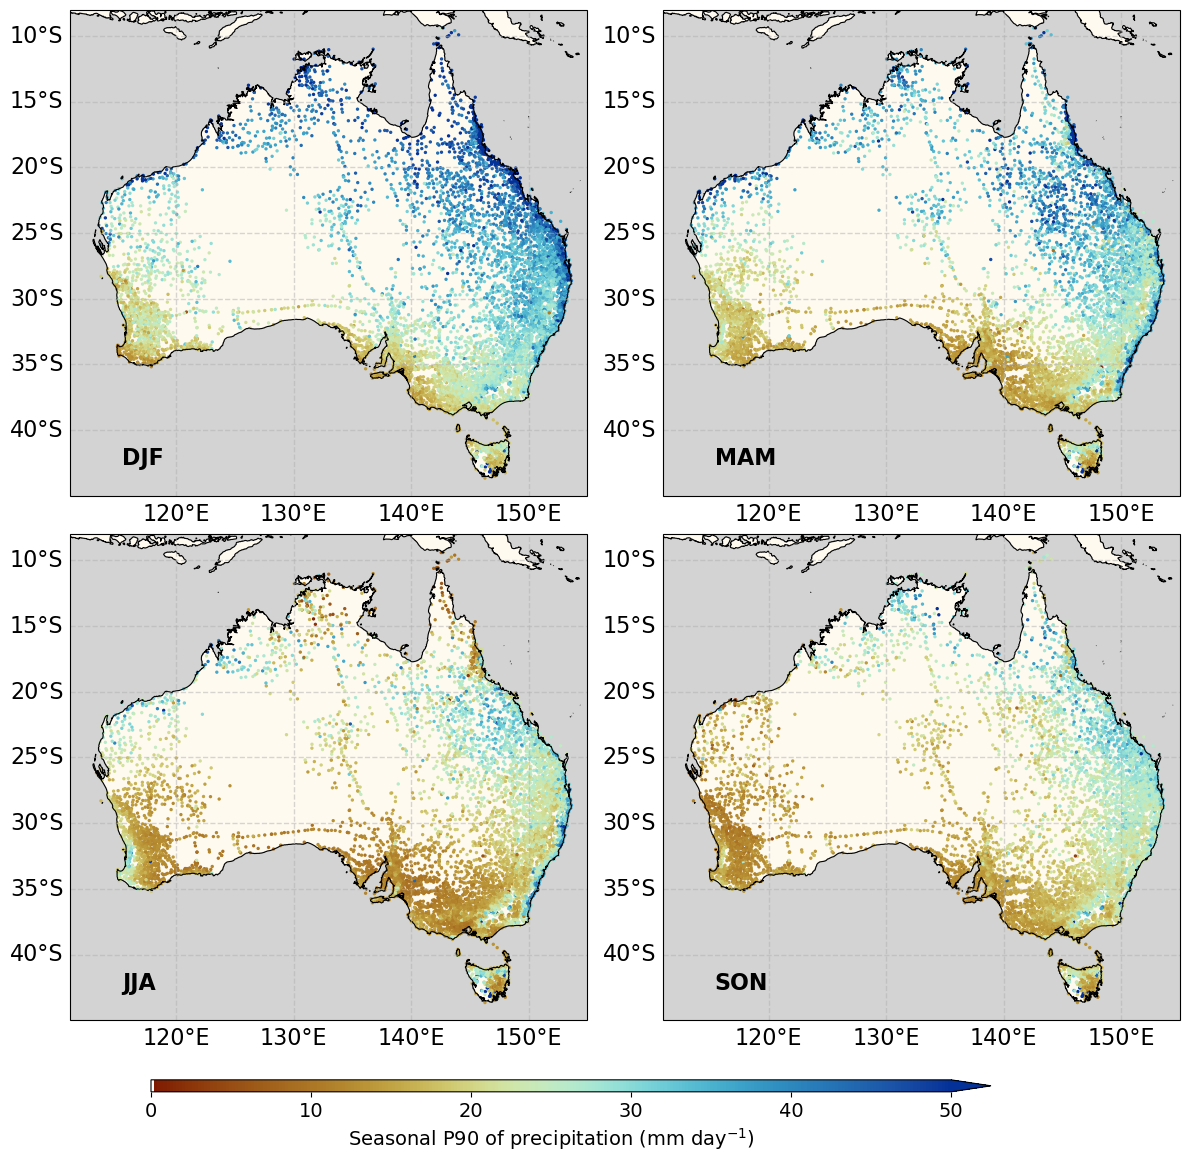

In [30]:
fig = plt.figure(figsize=(12,12))
for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    img = plt.scatter(df["Longitude"], df["Latitude"], s = 2, c= df_season[season], cmap=custom_cmap,vmin = 0, vmax=50,#norm=mcolors.LogNorm(vmax=1000),
                transform=ccrs.PlateCarree())
    # cbar = plt.colorbar(extend="max", pad =0.01)
    # cbar.ax.set_ylabel("P90 values (mm day$^{-1}$)")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16}  # Font size for longitude labels
    gl.ylabel_style = {'size': 16}  # Font size for latitude labels
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='lightgrey')  
    ax1.set_ylim([-45,-8])
    ax1.set_xlim([111,155])
    ax1.text(0.1, 0.1, season, transform=ax1.transAxes, fontsize=16, color="k", fontweight="bold",
                 verticalalignment='top')
    ## have this so the plots are the same size
    regions_gdf.plot(ax=ax1, color="w", edgecolor="w", alpha=0,zorder=0)
plt.tight_layout()
fig.subplots_adjust(bottom = 0.13)

cbar_ax = fig.add_axes([0.13, 0.078, 0.7, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(img,  cax = cbar_ax, orientation = "horizontal",extend ="max")#,ticks=[-1,1])
cbar.ax.set_xlabel("Seasonal P90 of precipitation (mm day$^{-1}$)")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_02_seasonal_P90.png", dpi=200, bbox_inches="tight")